# Tools and Programming Languages for Data Science: Project 1 

### Notes: 

- I will use the abbreviations df/dfs for dataframe/s in this Notebook.
- I will use the term "sub df" (=subset dataframe) for dataframes which I sliced out from another dataframe.
- For exercise 1 it was necessary to get a first overview of all datasets and to discover entries, values, dtypes etc. that needed to be fixed. I got this "first overview" in a seperate notebook and don't show it here, because that would be too much. But mostly you will know what I explored, as I explain many of my steps in exercise 1 with it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Of course the first task is to read in all data files:

In [2]:
# 1. Read in all files/data -> all contained in a folder with name "data_project1"

years = [year for year in range(2006, 2016+1, 2)] # create list with years of the Olympics -> can be changed easily if needed for more datasets
olympics_dict = {}                                # all variables will be stored in a dictionary -> key = string with year, value = df

for year in years:                                # read files in loop and append dictionary 
    olympics_dict["olympics_{0}".format(year)] = pd.read_csv("data_project1/results_{0}.csv".format(year)) 


# 2. Also read the metadata stored in excel file 
athletes_data = pd.read_excel("data_project1/metadata.xlsx", sheet_name="athletes")
games_data = pd.read_excel("data_project1/metadata.xlsx", sheet_name="games", header=3)

# Exercise 1

First I checked all CSV datasets. All dataframes have the same structure, meaning they have the same column names in the same order with the same respective data types WITH ONE EXCEPTION: in all dataframes the column "position" is dtype=float64 but in "olympics_2012" this column is dtype=object. 
I checked the "olympics_2012" dataframe and the likely reason for the different dtype is, that in column "position" there is one number written as a word and not as a number ("Fourty-Two" instead of 42.0). Therefore I to fix this by replacing the word with the respective float number, followed by a conversion of the "position" column to dtype=float64. Note that I wanted to replace the word through chained assignment with column.replace("Fourty-Two", 42.0, inplace=True) but then I get a FutureWarning because there will be changes for pandas 3.0. As I don't want to have this warning all the time I execute the cell, I use a slightly different method to alter the column.

After that we have the same column names in the same order with the same respective data type in each "olympics_xxxx" df:

In [3]:
#olympics_dict["olympics_2012"].position.replace("Fourty-Two", 42.0, inplace=True)                             # replacing method with FutureWarning
olympics_dict["olympics_2012"].position = olympics_dict["olympics_2012"].position.replace("Fourty-Two", 42.0)  # replace word value with float    
olympics_dict["olympics_2012"][["position"]] = olympics_dict["olympics_2012"][["position"]].astype(float)      # convert whole column to float

Then I want to add three columns to each of the six dataframes: year, country and city of the respective Olympic Games. I can get this information from the metadata file (see variable "games_data"), however the data is not in chronological order AND there is no data for 2008. Fortunately it's easy to get all the information for the 2008 Olympics with a Google search, so I add it manually. After that, I sort the games_data df by "year":

Note: There are still missing values in the "opened" and "closed" columns, but not for the olympics I'm examining. However if you want to include other olympic games, you should check the values in the two columns.

In [4]:
games_data.rename(columns={"country": "host_country", "city": "host_city"}, inplace=True)
games_data.loc[50.5] = 2008, "Summer", "Beijing", "People's Republic of China", "2008-08-08", "2008-08-24"
games_data.sort_values(by="year", inplace=True)
games_data.reset_index(drop=True, inplace=True)

Then I use the list "years", which I already used for reading in all CSV files, to insert columns with the year, host city, opening and closing dates to all results dataframes. Instead of inserting a host city column someone may insert a host country column. But that could be a bit confusing because there already is a "country" column in each of the results dfs, which contains the nationalities of the athletes. 

Finally I use pd.concat() to concat the six results dfs on top of each other. This works well because they have the same number of columns, with the same column names in the same order. Additionally the concated df will start with the results from 2006 and end with the ones from 2016, so there is a first chronological structure. I store it in the variable "results_data":

In [5]:
for year in years: 
    
    host_city = games_data[games_data.year == year].host_city.item()
    opening_date = games_data[games_data.year == year].opened.item()                     # get opening date of olympics in that year
    closing_date = games_data[games_data.year == year].closed.item()                     # get closig date of olympics in that year

    olympics_dict["olympics_{0}".format(year)].insert(0, "year", year)                   # add year column with values to each results df
    olympics_dict["olympics_{0}".format(year)].insert(1, "host_city", host_city)      # add host city column with values to each results df
    olympics_dict["olympics_{0}".format(year)].insert(2, "opening_date", opening_date)   # add opening date column with values to each results df
    olympics_dict["olympics_{0}".format(year)].insert(3, "closing_date", closing_date)   # add closing date column with values to each results df

results_data = pd.concat(olympics_dict.values()) 

Now let's look at the df with the metadata of the athletes, stored in variable "athletes_data". I have to make some small changes in it, before I merge it with the "results_data" df. Specifically I split the "name" column in two columns "first_name" and "last_name" with the "•" as the seperator. After that I drop the columns "name", "measurements", "died" and "affiliations" because we don't need them for this project and all of them have a lot of missing values. So I don't think they would be useful for any further evaluation. Finally I searched the birth date of the athlete with ID 117719 and add this information, as this is the only NaN value in column "born":

In [6]:
# First, apply changes to athletes_data:
athletes_data[["first_name", "last_name"]] = athletes_data["name"].str.split("•", expand=True) # split "name" column
athletes_data.drop(columns=["name", "measurements", "died", "affiliations"], inplace=True)     # drop columns 
no_birth_index = athletes_data[athletes_data.born.isna()].index.item()     # index of athlete without birthdate
athletes_data.loc[no_birth_index, "born"] = "1990-01-08"                   # add birthdate to athlete

After fixing all of these issues I can merge "athletes_data" with "results_data" via the column "athlete_id". The merged df will be stored in a new variable "olympics_df", which I will use for the following exercises. For "olympics_df" I convert the columns "position" and "athlete_id" from float to int and the columns "opening_date", "closing_date" and "born" from object to datetime. Also I reorder the columns for a more logical structure. I want the columns to start with general data related to the Olympics followed by the data related to the athletes (so from left to right it get's more detailed).

In [7]:
# Merging "athletes_data" with "results_data":
olympics_df = pd.merge(left=results_data, right=athletes_data, on="athlete_id", how="outer")             # merge dfs
olympics_df[["position", "athlete_id"]] = olympics_df[["position", "athlete_id"]].fillna(0).astype(int)  # replacing NaN with 0 and convert columns to int 

olympics_df[["opening_date", "closing_date", "born"]] = olympics_df[["opening_date", "closing_date", "born"]].apply(  # convert date columns to datetime
                                                        lambda x: pd.to_datetime(x).dt.date)             # dt.date -> just date without time


# Reorder columns of olympics_df
olympics_df = olympics_df[["year", "season", "host_city", "opening_date", "closing_date", "sport", "event", "position",  # reorder columns
                           "medal", "country", "team", "athlete_id", "first_name", "last_name", "sex", "born"]]    

Let's finish with the last task for exercise 1. I sort the dataframe permanently by year, sport, event and position. Also I display the first 3 and last 3 rows and print the number of rows and columns as mentioned in the task:

In [8]:
# Sort df by year, sport, event and position:

olympics_df.sort_values(by=["year", "sport", "event", "position"], inplace=True)  # sort df by year, sport, event and position
olympics_df.reset_index(drop=True, inplace=True)                                  # reset index

In [9]:
# Display first 3 rows:  

print("First 3 rows of olympics_df:") 
olympics_df.head(n=3)

First 3 rows of olympics_df:


,year,season,host_city,opening_date,closing_date,sport,event,position,medal,country,team,athlete_id,first_name,last_name,sex,born
0,2006,Winter,Torino,2006-02-10,2006-02-26,Alpine Skiing,"Combined, Men",0,NaN,Norway,NaN,88005,Lasse,Kjus,Male,1971-01-14
1,2006,Winter,Torino,2006-02-10,2006-02-26,Alpine Skiing,"Combined, Men",0,NaN,Norway,NaN,99335,Kjetil André,Aamodt,Male,1971-09-02
2,2006,Winter,Torino,2006-02-10,2006-02-26,Alpine Skiing,"Combined, Men",0,NaN,South Africa,NaN,99507,Alex,Heath,Male,1978-09-21


In [10]:
# Display last 3 rows:

print("Last 3 rows of olympics_df:")
olympics_df.tail(n=3)

Last 3 rows of olympics_df:


,year,season,host_city,opening_date,closing_date,sport,event,position,medal,country,team,athlete_id,first_name,last_name,sex,born
54273,2016,Summer,Rio de Janeiro,2016-08-05,2016-08-21,Wrestling,"Welterweight, Greco-Roman, Men",16,NaN,Hungary,NaN,117165,Tamás,Lőrincz,Male,1986-12-20
54274,2016,Summer,Rio de Janeiro,2016-08-05,2016-08-21,Wrestling,"Welterweight, Greco-Roman, Men",17,NaN,Kyrgyzstan,NaN,134915,Ruslan,Tsarev,Male,1991-07-16
54275,2016,Summer,Rio de Janeiro,2016-08-05,2016-08-21,Wrestling,"Welterweight, Greco-Roman, Men",18,NaN,Egypt,NaN,133610,Adham,Saleh,Male,1993-06-27


In [11]:
# Display number of rows and columns:

row_num = olympics_df.shape[0]
col_num = olympics_df.shape[1]
print("The final dataframe is stored in the variable 'olympics_df' and has", row_num, "rows and", col_num, "columns.")

The final dataframe is stored in the variable 'olympics_df' and has 54276 rows and 16 columns.


# Exercise 2

To get the woman who won the Gold medal in the 100 meters race of the 2012 olympic games, I just use conditions on the "year", "event" and "position" columns. This leads to the row/entry with the wanted athlete, which is stored in the variable "get_wmn". From this variable the name can be extracted and printed easily, by calling the item()-function on the "first_name" and "last_name" column:

In [12]:
# Which woman won the Gold medal in the 100 meters race of the 2012 olympic games?

get_wmn = olympics_df[(olympics_df.year == 2012)                   # use conditions to find entry in df
                      & (olympics_df.event == "100 metres, Women") 
                      & (olympics_df.position == 1)] 

get_wmn_first_name = get_wmn.first_name.item()  # get first name of athlete
get_wmn_last_name = get_wmn.last_name.item()    # get last name of athlete
print(get_wmn_first_name, get_wmn_last_name, "won the gold medal in the 100 metres women race of the 2012 olympic games.")

Shelly-Ann Fraser-Pryce won the gold medal in the 100 metres women race of the 2012 olympic games.


Now let's move on to the athletes with the most gold medals for different countries. First I create a sub df "winners", which just contains entries with the value "Gold" in the "medal" column, and I create a list with countries to evaluate. Then I iterate over this list to check if there is any athlete from the current country in the "winners" df. If this isn't the case, no athlete from this country won a gold medal in any of the olympics from 2006 to 2016. For further evaluation I group the "winners" df by country and get the group with the current one, stored in "winners_of_country". So then I would have a df with all gold medal winners of a specific country from 2006 to 2016. In this df I just can use value_counts() on the "athlete_id" column, to get the ID of the athlete with the highest occurance and the respective count number (which is the count number of gold medals for this athlete). I store both values in variables and use the athlete ID to find the first and last name of the corresponding athlete. It doesn't matter in which df we use the ID to search for the name, as it's obviously the same everywhere. In the end I use some conditional statements to print out the result in a grammatically correct sentences:

In [13]:
# Which athlete has won the most gold medals, considering only athletes from the following countries: 
# “Jamaica”, “Trinidad and Tobago”, “Barbados”, “Grenada”, “Saint Kitts and Nevis”?

winners = olympics_df[olympics_df.medal == "Gold"]                         # df which just contains entries with a gold medal
countries_to_search  = ["Jamaica", "Trinidad and Tobago", "Barbados",      # list of countries to search for gold medal winners -> easy to change
                        "Grenada", "Saint Kitts and Nevis"]                

for country in countries_to_search:
    if any(winners.country == country):                                          # check if current country occures in "winners" df
        winners_of_country = winners.groupby(["country"]).get_group((country,))  # group "winners" df by country and get current country group
        max_winner_index = winners_of_country[["athlete_id"]].value_counts().index[0]     # get index (=athlete_id) of most occuring athlete 
        max_winner_medal_count = winners_of_country[["athlete_id"]].value_counts().max()  # get max value (= number of gold medals) of this athlete                      
        max_winner_first_name = winners[winners.athlete_id==max_winner_index].iloc[0].first_name  # get first name of athlete
        max_winner_last_name = winners[winners.athlete_id==max_winner_index].iloc[0].last_name    # get last name of athlete
        
        if max_winner_medal_count ==1:
            print("For", country, "the athlete with the most gold medals is", 
                  max_winner_first_name, max_winner_last_name, "with", max_winner_medal_count, "gold medal.")
        else:
            print("For", country, "the athlete with the most gold medals is", 
                  max_winner_first_name, max_winner_last_name, "with", max_winner_medal_count, "gold medals.")
    else:
        print(country, "doesn't have any gold medal winners in this dataset.")


For Jamaica the athlete with the most gold medals is Usain Bolt with 8 gold medals.
For Trinidad and Tobago the athlete with the most gold medals is Marc Burns with 1 gold medal.
Barbados doesn't have any gold medal winners in this dataset.
For Grenada the athlete with the most gold medals is Kirani James with 1 gold medal.
Saint Kitts and Nevis doesn't have any gold medal winners in this dataset.


When I search for the best, worst and average position achieved by athletes from Nepal I have to consider that I converted the "position" column to dtype int. Therefore all NaN values in this column were converted to 0. Therefore I get the sub df "nepal_df" which just contains athletes from Nepal and excludes all entries where the "position" column has the value 0. There is not much to explain, so I just provided some comments in the code cell. Also I did a little extra research, because I wanted to provide the names of the athletes with the best/worst positions. For this you also find some comments in the next cell because I don't want this explanation to be too long but and this part wasn't explicitly asked for. I output the "exact" average/mean as a decimal number together with the orresponding rounded number because the position in a sports tournament is a positive integer.

In [14]:
# What was the best position, worst position, and average position achieved by athletes from “Nepal”?

nepal_df = olympics_df[(olympics_df.country=="Nepal") & (olympics_df.position!=0)]  # get df of athletes from Nepal with no missing "position" value
nepal_best_position = nepal_df.position.min()                                       # min value = best position
nepal_worst_position = nepal_df.position.max()                                      # max value = worst position
nepal_avg_position = nepal_df.position.mean().round(2)                              # average position of all athletes from Nepal
nepal_round_avg_position = int(nepal_avg_position.round(0))                         # rounded average position of all athletes from Nepal


# EXTRA: output the athlete names who achieved the best/worst positions by finding them via the best/worst position value:

best_athletes = olympics_df[(olympics_df.country=="Nepal") & (olympics_df.position==nepal_best_position)]  # get athletes with best positions
best_athletes_names = []                                                                                   # list for names of best athletes 
for i in range(len(best_athletes)):
    best_athletes_names.append(best_athletes.iloc[i].first_name + " " + best_athletes.iloc[i].last_name)   # concat first and last names to one string

print("The best position achieved by athlete/s from Nepal is position", nepal_best_position,"by following athlete/s:")
for i in range(len(best_athletes_names)):
    print(best_athletes_names[i])
print()


worst_athletes = olympics_df[(olympics_df.country=="Nepal") & (olympics_df.position==nepal_worst_position)]  # get athletes with worst positions
worst_athletes_names = []                                                                                    # list for names of best athletes
for i in range(len(worst_athletes)):
    worst_athletes_names.append(worst_athletes.iloc[i].first_name+ " " + worst_athletes.iloc[i].last_name)  # concat first and last names to one string

print("The worst position achieved by athlete/s from Nepal is position", nepal_worst_position,"by following athlete/s:")
for i in range(len(worst_athletes_names)):
    print(worst_athletes_names[i])

print()
print("The average position achieved by athlete/s from Nepal is " + str(nepal_avg_position) + 
      ", which means the rounded average position is "+ str(nepal_round_avg_position) + ".")

The best position achieved by athlete/s from Nepal is position 7 by following athlete/s:
Deepak Bista
Nisha Rawal

The worst position achieved by athlete/s from Nepal is position 94 by following athlete/s:
Dachhiri Sherpa

The average position achieved by athlete/s from Nepal is 47.78, which means the rounded average position is 48.


# Exercise 3

For this exercise I create a list, which contains the years of the olympics to evaluate, and two dictionaries (summer and winter olympics) in which I will store the years as keys and the number of participants as values. I use a loop to iterate over the year list to get a df of the results just for the olympics of a current year. In this year in count the number of unique values in the "athlete_id" column, which equals the number of participants for the olympic games in this year. Finally I use a condition on the "season" column to either append my summer or winter dictionary with the year as key and the number of participants as value. 

Note: In the end I just check the "season" column of the first row, as all values in this column are the same for the olympic games in a certain year.

In [15]:
years = [year for year in range(2006, 2016+1, 2)]  # list with years of olympics  
participants_summer = {}                           # dictionary for summer olympics: key = year ; value = number of participants
participants_winter = {}                           # dictionary for summer olympics: key = year ; value = number of participants

for year in years:
    olympics_of_year = olympics_df[olympics_df.year == year]
    num_participants_of_year = olympics_of_year.athlete_id.nunique(dropna=True)

    if olympics_of_year.iloc[0].season == "Summer":
        participants_summer[year] = num_participants_of_year
    elif olympics_of_year.iloc[0].season == "Winter":
        participants_winter[year] = num_participants_of_year
    else:
        print("There is an invalid value in the season column")

Let's get a visualization how the number of participants has changed over the years. There is not much to explain, I used the lecture slides and the seaborn documentation to make the graphic a bit more appealing.

[Text(0, 0, '2504'), Text(0, 0, '2553'), Text(0, 0, '2772')]

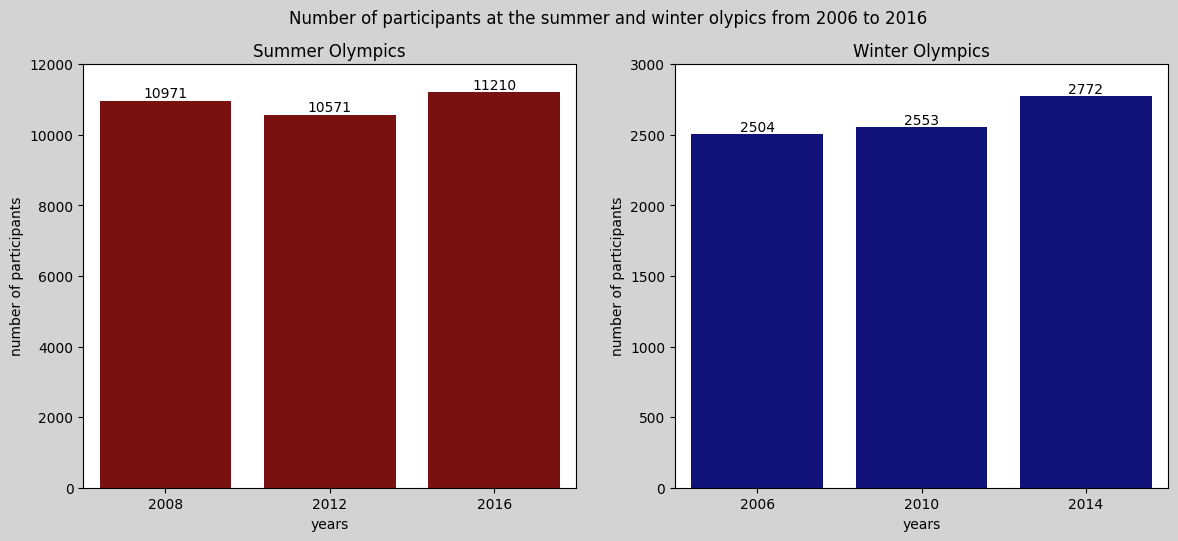

In [16]:
fig, ax = plt.subplots(ncols=2, nrows=1)

fig.set_size_inches(14,5.5)
fig.suptitle("Number of participants at the summer and winter olypics from 2006 to 2016")
fig.set_facecolor("lightgrey")

ax1 = sns.barplot(data=participants_summer, x=list(participants_summer.keys()), y=list(participants_summer.values()), ax=ax[0], color="darkred")
ax1.set_title("Summer Olympics")
ax1.set_xlabel("years")
ax1.set_ylabel("number of participants")
ax1.set_ylim((0, 12000))
ax1.bar_label(ax1.containers[0])

ax2 = sns.barplot(data=participants_winter, x=list(participants_winter.keys()), y=list(participants_winter.values()), ax=ax[1], color="darkblue")
ax2.set_title("Winter Olympics")
ax2.set_xlabel("years")
ax2.set_ylabel("number of participants")
ax2.set_ylim((0, 3000))
ax2.bar_label(ax2.containers[0])

# Exercise 4

First I create a sub df which just contains entries from 2016 and I group them by last name. In these groups there can be different athlete IDs as different athletes can have the same last name. Therefore I count the distinct athlete_id values in each group with .nunique(). Consequently, for every last name I get the info how many distinct ahletes have this name. Therefore the max value corresponds to the most common last name among the athletes.

In [17]:
sub_df_2016 = olympics_df[olympics_df.year == 2016].groupby("last_name") # create sub df with entries from 2016 and group bx-y last name

count_last_names = sub_df_2016.athlete_id.nunique()            # count different athlete IDs in each group
max_id_count = count_last_names.max()                          # get max value of athlete_id count (= number of athletes with same last name)
last_names_df = count_last_names.to_frame().reset_index()      # convert series with original index last name to df and reset idex
last_names_df.rename(columns={"athlete_id": "occurance"}, inplace=True)                 # rename column "athlete_id" (contains counts) to "occurance"
last_name = last_names_df[last_names_df.occurance == max_id_count].last_name.item() # get most common last name among the athletes

print("The most common last name among the athletes is the last name '" + last_name + "' which occures " + str(max_id_count) + 
      " times, so it is shared by " + str(max_id_count) + " athletes.")


The most common last name among the athletes is the last name 'López' which occures 29 times, so it is shared by 29 athletes.


# Exercise 5

First of all, there are multiple ways to calculate the average age and the preciseness of it. Someone would argue that you take just the full years of an athlete at the time of the beginning of the olympics (e.g. 25 years). This argument is understandable because in normal daily situations probably everyone says their age in full years and not 'I'm 25.36" years old. However I would like to calculate it to calculate it a bit more precisely, so I use the Pandas Timedelta class to calculate the difference between the "opening_date" an "born" column. Unfortunately this class can't return the difference in months or years but just in days or smaller timeframes. Therefore I decided to divide the day difference by 365.25, which is the number of days per year (taking leap years into consideration). On this way I get every athlete's age as the number of years between birth and opening date (as defined) BUT this number will still be a float because I want the end result to be relatively exact.


I can reuse the the df stored in the vatriable "winners" from exercise 2, when I searched for the athletes with the most gold medals for some countries. First I calculate the age for each gold medal winner via an apply and lambda function and store it a new column "age" in the df with the gold medal winners. Then I group this df by sports and calculate the mean of the age column for every group. At the end I sort the results by an descending order and output the 5 sport with the highest average age of gold medal winners:

In [18]:
age = winners.apply(lambda row: pd.Timedelta(row.opening_date - row.born).days/365.25, axis=1) # calculate age for every gold medal winner
winners.insert(16, column="age", value=age)                                                    # append age column to winners df
sorted_winner_avg_age_per_sport = winners.groupby("sport").age.mean().sort_values(ascending=False).reset_index() # calculate + sort average age per sports
sorted_winner_avg_age_per_sport.rename(columns={"age":"average_age"}, inplace=True)            # rename column for avergage age 

print("The 5 sports with the highest average age of gold medal winners are:")
print()

for i in range(0,5,1):
    print(sorted_winner_avg_age_per_sport.iloc[i].sport + ": " + str(round(sorted_winner_avg_age_per_sport.iloc[i].average_age, ndigits=1)) + " years")

#sorted_winner_avg_age_per_sport.iloc[0:5]    # uncomment this code, of you want to have the result as a df

The 5 sports with the highest average age of gold medal winners are:

Equestrian Jumping: 42.5 years
Equestrian Eventing: 38.0 years
Equestrian Dressage: 36.4 years
Curling: 33.4 years
Cycling Road: 32.4 years


# Exercise 6

First I get a sub df with all entries from the 2016 olympics where the value in the "medal" column is not NaN and store it in "medals_2016". Then I create a list which contains all the unique countries of that new df. Furthermore I use a dictionary with these unique countires as keys. The value for each key (each country) will be a list with 4 items: gold count, silver count, bronze count, total count. At the beginning every country's list will be [0,0,0,0]. So in the end I want to have a dictionary like this: {"United States": [1,2,3,6], "Germany": [2,3,5,10], ...}

I use a loop to iterate over the list with the unique countries with any medal in 2016 and for every country there will be a nested loop to iterate over the medal values ("Gold", "Silver", "Bronze"). The variable "medal_index" describes the position of the medal in the list, which contains the medals for the current country. For every medal I take the rules for counting into consideration (e.g. medals for a whole team counts as one medal). So I apply value_counts() for the 2 columns "sport" and "event". By doing this, I get a series which contains the counted medals for every specific event in any specific sport. I'm not interested in these counts but in the length of the series itself, as this legth is the official medal count. As my explanation might be a bit confusing here is an example:

Country X just has athletes who won gold medals (no silver and bronze): one athlete in Athletics 100m Men; the Women Beachvolleyball Team (2 athletes and the Women Volleyball Team (12 athletes) -> the value_counts()-series would look like this: [1,2,12] -> the length is 3 which would be the official gold medal count for this country.

I apply this method to every medal and in the end I sum the the three values to get the total medal count. In the end I just convert the dictionary to a df and aplly some transformations, so my final table looks like the official one. I don't want to explain it in detail here as this text is already pretty long. But I added some comments in the corresponding cell.

In [19]:
# First: Getting all medals/values which I need for the medal table

medals_2016 = olympics_df[(olympics_df.year == 2016) & olympics_df.medal.notna()==True] # df with countries that won any type of medal in 2016 
countries_any_medals_2016 = list(medals_2016.country.unique())                          # list with unique countries in medals_2016 df (see line above)
countries_medals_count = {country: [0,0,0,0] for country in countries_any_medals_2016}  # keys = countries, values = list for each country with 4 items:
                                                                                        # gold, silver, bronze and total medal count

medals = ["Gold", "Silver", "Bronze"]             # list with medal values

for country in countries_any_medals_2016:         # iterate over countries with any type of medal in 2016
    medal_index = 0                               # position index of medal in list for current country        
    for medal in medals:                          # iterate over list with medal values
        current_medal = medals_2016[(medals_2016.country == country) & (medals_2016.medal == medal)]  # search for current medal value of current country   
        medal_count = len(current_medal[["sport", "event"]].value_counts())  # count values by sport and event and get length (number of rows) of that df
        countries_medals_count[country][medal_index] = medal_count           # set medal_count of current medal for current country
        medal_index += 1                                                     # add 1 to medal index for next medal value

        if medal =="Bronze":                                                                     # if we counted gold, silver and bronze medals:
            countries_medals_count[country][medal_index] = sum(countries_medals_count[country])  # calculate and set total number of medals 
            medal_index = 0                                                                      # reset medal index for next country


In [20]:
# Second: converting dictionary to df and transform df so it look like the official medal table

medal_table = pd.DataFrame.from_dict(countries_medals_count, orient="index", columns=["Gold", "Silver","Bronze", "Total"]) # transform dict to df
medal_table.sort_values(by=["Gold", "Silver", "Bronze"], ascending=[False, False, False], inplace=True)   # sort df according to medal table rules
medal_table.reset_index(inplace=True)                          # before reset: index = country names -> reset
medal_table.rename(columns={"index": "NOC"}, inplace=True)     # after reset: all countries in column named "index" -> rename column to "NOC"
medal_table.index += 1                                         # because we reseted index: new index starts at 0 -> add 1 to use it later as "Rank"
medal_table.reset_index(inplace=True)                          # reset index again 
medal_table.rename(columns={"index": "Rank"}, inplace=True)    # again, rename the "old" index column to "Rank" (that's why I added 1)
medal_table.iloc[0:10].style.hide()                            # get first 10 countries and display without index


Rank,NOC,Gold,Silver,Bronze,Total
1,United States,46,37,38,121
2,Great Britain,27,23,17,67
3,People's Republic of China,26,18,26,70
4,Russian Federation,19,17,20,56
5,Germany,17,10,15,42
6,Japan,12,8,21,41
7,France,10,18,14,42
8,Republic of Korea,9,3,9,21
9,Italy,8,12,8,28
10,Australia,8,11,10,29
